In [1]:
from datetime import timedelta, datetime
from ast import literal_eval
from pathlib import Path
import random
import numpy as np
import pandas as pd
from tqdm import tqdm
from collections import Counter
import gc
from scipy.sparse import csr_matrix
from functools import reduce
import os

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme()

%matplotlib inline
tqdm.pandas()

In [2]:
LOCAL = False
DATA_PATH = Path("./data") if LOCAL else Path("/kaggle/input/what-card-should-i-select-next")

In [3]:
# Get the data
dfp_train = pd.read_csv(DATA_PATH/"train.csv")
dfp_test = pd.read_csv(DATA_PATH / "test.csv")
dfp_cards = pd.read_csv(DATA_PATH / "cards.csv")

In [4]:
dfp_train

,deckid,update_date,hero,is_wild,is_standard,cards
0,b5407c84-8aa8-420d-9cd4-162eeee8762f,2013-05-23,paladin,True,False,"[21, 21, 142, 206, 206, 350, 350, 394, 422, 42..."
1,03376e41-6934-4ebd-9256-5a96c1760ac7,2013-05-23,paladin,True,False,"[53, 142, 206, 250, 318, 350, 355, 394, 439, 4..."
2,72301a26-1825-4ec4-88aa-132ac97da5e1,2013-05-23,shaman,True,False,"[67, 67, 77, 77, 84, 84, 216, 233, 233, 388, 4..."
3,60273017-9a7a-4336-bc31-d5bcf662d3ef,2013-05-24,shaman,True,False,"[54, 54, 140, 217, 289, 289, 510, 510, 526, 52..."
4,dfc220aa-6253-4d2f-8707-47523e3ae88a,2013-05-24,shaman,True,False,"[55, 55, 88, 88, 152, 152, 217, 275, 275, 289,..."
...,...,...,...,...,...,...
606936,6e992855-bcb1-4bd1-b425-0b06c4002830,2018-08-28,warrior,True,False,"[55523, 55524, 55524, 55529, 55529, 55535, 769..."
606937,2fb6eae8-a11e-457f-b098-9783b65529a4,2018-08-28,warrior,True,False,"[664, 664, 55517, 55517, 55523, 55529, 55529, ..."
606938,54f03512-36b3-4cdd-9895-28c5c7372dd4,2018-08-28,mage,True,False,"[4, 4, 49, 49, 220, 55552, 55552, 55553, 55553..."
606939,7b1abfd8-1311-4e60-ad20-bcccf5cf4462,2018-08-28,paladin,True,False,"[581, 581, 12188, 12188, 12200, 12200, 12216, ..."


In [5]:
dfp_test

,deckid,update_date,hero,is_wild,is_standard,cards_incomplete
0,90509acf-14b3-46c2-baab-94226b4f1ae5,2018-08-29,priest,True,False,"[38, 38, 88, 88, 303, 315, 315, 401, 415, 415,..."
1,edbc7193-15d8-4d63-813a-8b02896aebaf,2018-08-29,paladin,True,False,"[75, 75, 463, 567, 567, 675, 61831, 61832, 618..."
2,3e1e5712-c7de-4e4b-83b0-639fbeedd98f,2018-08-29,hunter,True,False,"[386, 386, 12176, 12188, 12188, 12190, 12254, ..."
3,27037494-cbdc-4f25-a479-a6d266361f07,2018-08-29,priest,True,False,"[315, 431, 431, 52588, 55463, 55463, 55540, 55..."
4,6a307895-2441-4ebf-9653-6b54e2e0111b,2018-08-29,mage,True,False,"[4, 4, 49, 49, 220, 55552, 55552, 55553, 55553..."
...,...,...,...,...,...,...
2216,b99e946f-502e-4ed3-b76b-2001408602f1,2018-09-17,priest,True,False,"[207, 207, 303, 431, 431, 436, 62886, 62886, 6..."
2217,950ad114-5fda-41b9-a469-3d1da5be356d,2018-09-17,druid,True,False,"[154, 154, 619, 619, 73327, 73327, 76870, 7687..."
2218,cc5f646c-299d-4347-9099-381fe0fe7b21,2018-09-17,priest,True,False,"[76, 431, 431, 442, 554, 55463, 55463, 55540, ..."
2219,e9fe9eef-3201-4df0-9342-faaa305f3553,2018-09-17,mage,True,False,"[4, 4, 177, 177, 263, 263, 411, 411, 589, 589,..."


In [6]:
# convert str 'cards' to list
dfp_train["cards"] = dfp_train["cards"].progress_apply(lambda cards: literal_eval(cards))
dfp_test["cards_incomplete"] = dfp_test["cards_incomplete"].progress_apply(lambda cards: literal_eval(cards))

100%|██████████| 2221/2221 [00:00<00:00, 21048.90it/s]


In [7]:
# change update_date to datetime
dfp_train["update_date"] = pd.to_datetime(dfp_train["update_date"])
dfp_test["update_date"] =  pd.to_datetime(dfp_test["update_date"])

In [8]:
# oldest deck?
dfp_train["update_date"].min()

Timestamp('2013-05-23 00:00:00')

In [9]:
# add timedelta as int variable
last_train_update_date = dfp_train["update_date"].max()
last_train_update_date

Timestamp('2018-08-28 00:00:00')

In [10]:
dfp_train["update_delta"] = (last_train_update_date - dfp_train["update_date"]).dt.days
dfp_test["update_delta"] = (last_train_update_date - dfp_test["update_date"]).dt.days

In [11]:
dfp_test["update_delta"].value_counts().sort_index()

-20     91
-19     76
-18     50
-17    135
-16     80
-15     86
-14     75
-13    109
-12     91
-11    165
-10    176
-9     105
-8      87
-7      84
-6     124
-5     133
-4      90
-3     184
-2     147
-1     133
Name: update_delta, dtype: int64

In [12]:
np.ceil(dfp_train.update_delta.max() / 7)

275.0

In [13]:
# checking that there's no non-wild-nor-standard deck nor overlap
covers_all = lambda df: (df['is_wild'] | df['is_standard']).all()
has_overlap = lambda df: (df['is_wild'] & df['is_standard']).any()

covers_all(dfp_train), has_overlap(dfp_train)

(True, False)

In [14]:
covers_all(dfp_test), has_overlap(dfp_test)

(True, False)

In [15]:
# how many of each type in the train set?
dfp_train['is_wild'].sum(), dfp_train['is_standard'].sum()

(606917, 24)

In [16]:
# how many of each type in the test set?
dfp_test['is_wild'].sum(), dfp_test['is_standard'].sum()

(2221, 0)

No standard decks in the test set + there're only a few in the train set, are they at least from the last week?

In [17]:
dfp_train['update_date'][dfp_train['is_standard']].value_counts().sort_index()

2014-07-28    1
2014-08-02    1
2014-08-11    1
2015-03-09    2
2015-03-31    1
2015-04-01    1
2015-04-03    1
2015-04-10    1
2015-04-22    1
2015-06-07    1
2015-06-16    1
2015-08-20    1
2015-08-22    1
2015-11-18    1
2015-12-30    1
2016-04-08    1
2016-04-24    1
2016-10-13    1
2016-10-17    1
2016-12-15    1
2017-03-29    1
2017-05-24    1
2017-06-21    1
Name: update_date, dtype: int64

They're extremely sparse + the last one was over an year ago from latest train-set day -> dropping them

In [18]:
dfp_train = dfp_train[~dfp_train['is_standard']]
dfp_train['is_wild'].sum(), dfp_train['is_standard'].sum()

(606917, 0)

In [19]:
# dropping columns as now all decks are wild
dfp_train = dfp_train.drop(columns=['is_wild','is_standard'])
dfp_test = dfp_test.drop(columns=['is_wild','is_standard'])

In [20]:
all_heroes=dfp_train["hero"].unique().tolist()

In [21]:
weekly_counts = dfp_train
weekly_counts['week_update'] = weekly_counts.apply(lambda row: row['update_date'] - timedelta(days=row['update_date'].weekday()), axis=1)

weekly_counts = weekly_counts[['week_update','hero']].groupby(['week_update','hero'],as_index=False).size()
weekly_counts

,week_update,hero,size
0,2013-05-20,druid,16
1,2013-05-20,hunter,13
2,2013-05-20,mage,15
3,2013-05-20,paladin,24
4,2013-05-20,priest,16
...,...,...,...
2479,2018-08-27,priest,44
2480,2018-08-27,rogue,37
2481,2018-08-27,shaman,23
2482,2018-08-27,warlock,21


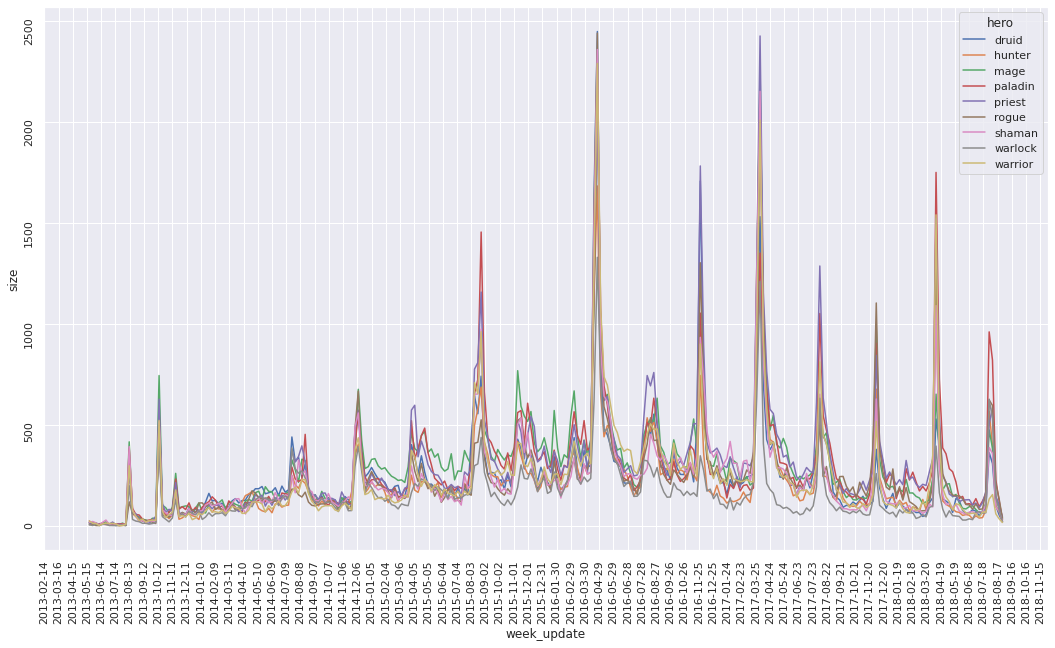

In [22]:
from matplotlib.ticker import MultipleLocator

fig, ax = plt.subplots(figsize=(18,10))
sns.lineplot(data=weekly_counts, x="week_update", y="size",hue="hero", ax=ax)
ax.xaxis.set_major_locator(MultipleLocator(30))
ax.tick_params(rotation=90)
plt.show()

In [23]:
monthly_counts = dfp_train
monthly_counts['month_update'] = monthly_counts.apply(lambda row: row['update_date'] - timedelta(days=row['update_date'].day), axis=1)

monthly_counts = monthly_counts[['month_update','hero']].groupby(['month_update','hero'],as_index=False).size()
monthly_counts

,month_update,hero,size
0,2013-04-30,druid,29
1,2013-04-30,hunter,26
2,2013-04-30,mage,28
3,2013-04-30,paladin,34
4,2013-04-30,priest,23
...,...,...,...
571,2018-07-31,priest,1328
572,2018-07-31,rogue,1496
573,2018-07-31,shaman,886
574,2018-07-31,warlock,1328


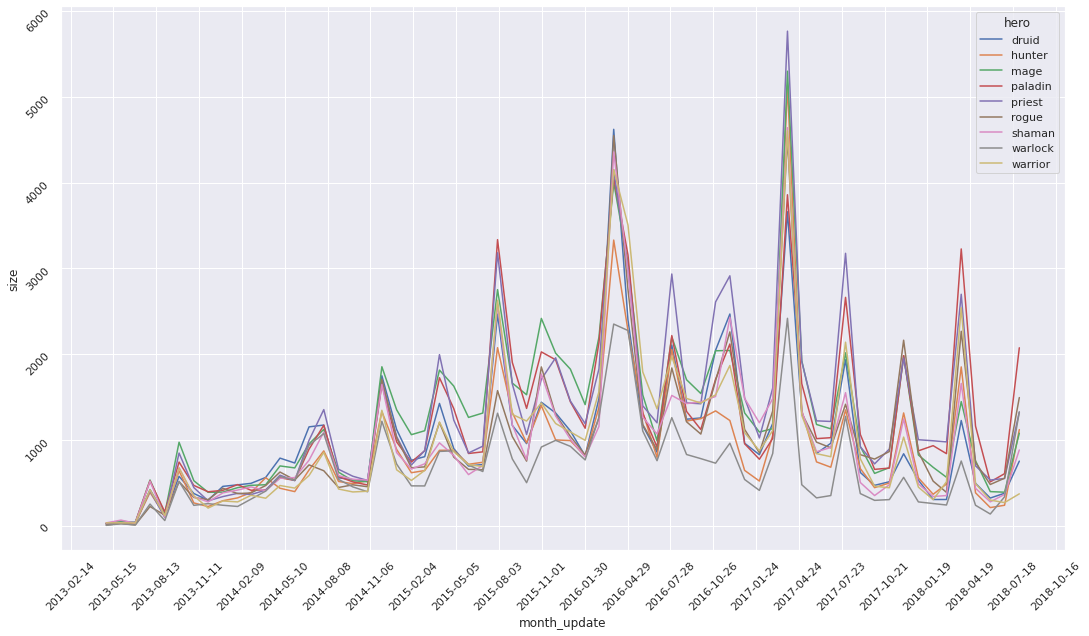

In [24]:
fig, ax = plt.subplots(figsize=(18,10))
sns.lineplot(data=monthly_counts, x="month_update", y="size",hue="hero")
ax.xaxis.set_major_locator(MultipleLocator(90))
ax.tick_params(rotation=45)
plt.show()

# Sanitizing decks

In [25]:
dfp_train.loc[0, "cards"]

[21,
 21,
 142,
 206,
 206,
 350,
 350,
 394,
 422,
 422,
 463,
 499,
 564,
 564,
 603,
 603,
 642,
 657,
 657,
 475033,
 475042,
 475042,
 475050,
 475050,
 475051,
 475051,
 475054,
 475054,
 475175,
 475175]

In [26]:
dfp_cards

,id,name,img,card_text,flavor_text,type,class,rarity,set,race,...,is_overload_card,is_lifesteal_card,is_freeze_card,is_discover_card,is_windfury_card,is_echo_card,is_secret_card,cost,attack,health
0,90145,"Shirvallah, the Tiger",https://cards.hearthpwn.com/enUS/TRL_300.png?1...,"Divine Shield, Rush, Lifesteal Costs (1) less ...",On bended knee Thekal placed his weapon upon S...,minion,paladin,legendary,rastakhan's rumble,beast,...,False,True,False,False,False,False,False,25,7,5
1,42049,Arcane Giant,https://cards.hearthpwn.com/enUS/KAR_711.png?1...,Costs (1) less for each spellyou've cast this ...,Claims to be drawn to Karazhan because of the ...,minion,NaN,epic,one night in karazhan,NaN,...,False,False,False,False,False,False,False,12,8,8
2,475011,Clockwork Giant,https://cards.hearthpwn.com/enUS/CORE_GVG_121....,Costs (1) less for each card in your opponent'...,He and Mountain Giant don't get along.,minion,NaN,epic,removed from core,mechanical,...,False,False,False,False,False,False,False,12,8,8
3,264,Mountain Giant,https://cards.hearthpwn.com/enUS/EX1_105.png?1...,Costs (1) less for each other card in your hand.,His mother said that he was just big boned.,minion,NaN,epic,legacy,elemental,...,False,False,False,False,False,False,False,12,8,8
4,31110,C'Thun,https://cards.hearthpwn.com/enUS/OG_280.png?14...,Battlecry: Deal damage equal to this minion's ...,C'Thun's least favorite Hearthstone card: Eye ...,minion,NaN,legendary,whispers of the old gods,NaN,...,False,False,False,False,False,False,False,10,6,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2623,55496,Molten Blade,https://cards.hearthpwn.com/enUS/UNG_929.png?1...,"Each turn this is in your hand, transform it i...",It’s a sword! It’s a knife! It’s a swizzle-stick!,weapon,warrior,rare,journey to un'goro,NaN,...,False,False,False,False,False,False,False,1,1,1
2624,329906,Sphere of Sapience,https://cards.hearthpwn.com/enUS/SCH_259.png?1...,"At the start of your turn,look at your top car...",This is what it sounds like when spheres scry.,weapon,NaN,legendary,scholomance academy,NaN,...,False,False,False,False,False,False,False,1,0,4
2625,42042,Spirit Claws,https://cards.hearthpwn.com/enUS/KAR_063.png?1...,Has +2 Attack while youhave Spell Damage.,They'll be MUCH easier to use once they add th...,weapon,shaman,common,one night in karazhan,NaN,...,False,False,False,False,False,False,False,1,1,3
2626,90271,Serrated Tooth,https://cards.hearthpwn.com/enUS/TRL_074.png?1...,Deathrattle: Give your minions Rush.,"The tooth hurts, don’t it?",weapon,rogue,common,rastakhan's rumble,NaN,...,False,False,False,False,False,False,False,1,1,3


In [27]:
dfp_cards.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2628 entries, 0 to 2627
Data columns (total 30 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   id                    2628 non-null   int64 
 1   name                  2628 non-null   object
 2   img                   2628 non-null   object
 3   card_text             2581 non-null   object
 4   flavor_text           2576 non-null   object
 5   type                  2628 non-null   object
 6   class                 1681 non-null   object
 7   rarity                2596 non-null   object
 8   set                   2628 non-null   object
 9   race                  715 non-null    object
 10  raw_attributes        2628 non-null   object
 11  is_battlecry_card     2628 non-null   bool  
 12  is_divineshield_card  2628 non-null   bool  
 13  is_rush_card          2628 non-null   bool  
 14  is_deathrattle_card   2628 non-null   bool  
 15  is_taunt_card         2628 non-null   

In [28]:
# set card ids as index
dfp_cards.set_index("id", inplace=True)

## Rarity shouldn't have missing values

In [29]:
_ = dfp_cards.iloc[:,:10][dfp_cards["rarity"].isna()]
print(len(_))
_.sort_index()

32


,name,img,card_text,flavor_text,type,class,rarity,set,race,raw_attributes
id,,,,,,,,,,
21,Squire,https://cards.hearthpwn.com/enUS/CS2_152.png?1...,NaN,NaN,minion,NaN,NaN,legacy,NaN,{}
53,Ashbringer,https://cards.hearthpwn.com/enUS/EX1_383t.png?...,NaN,NaN,weapon,paladin,NaN,legacy,NaN,{}
58,Rampant Growth,https://cards.hearthpwn.com/enUS/EX1_164a.png?...,Gain 2 Mana Crystals.,NaN,ability,druid,NaN,legacy,NaN,{}
63,Violet Apprentice,https://cards.hearthpwn.com/enUS/NEW1_026t.png...,NaN,NaN,minion,NaN,NaN,legacy,NaN,{}
141,The Coin,https://cards.hearthpwn.com/enUS/GAME_005.png?...,Gain 1 Mana Crystal this turn only.,"Whether you spend it or save it, it's always t...",ability,NaN,NaN,core (2022),NaN,{}
159,Shan'do's Lesson,https://cards.hearthpwn.com/enUS/EX1_573b.png?...,Summon two 2/2 Treants with Taunt.,NaN,ability,druid,NaN,legacy,NaN,{Taunt}
204,Leader of the Pack,https://cards.hearthpwn.com/enUS/EX1_160b.png?...,Give your minions +1/+1.,NaN,ability,druid,NaN,legacy,NaN,{}
219,Summon a Panther,https://cards.hearthpwn.com/enUS/EX1_160a.png?...,Summon a 3/2 Panther.,NaN,ability,druid,NaN,legacy,NaN,{}
231,Bananas,https://cards.hearthpwn.com/enUS/EX1_014t.png?...,Give a minion +1/+1.,NaN,ability,NaN,NaN,legacy,NaN,{}


In [30]:
df, deck_key = dfp_train, "cards"
(df.explode(deck_key).merge(dfp_cards["rarity"], left_on=deck_key, right_index=True, how='left')["rarity"].isna()).sum()

62

In [31]:
df, deck_key = dfp_test, "cards_incomplete"
(df.explode(deck_key).merge(dfp_cards["rarity"], left_on=deck_key, right_index=True)["rarity"].isna()).sum()

0

As no test decks have said invalid cards, we're dropping both the cards in the card set and the corresponding decks in the train set

In [32]:
invalid_cards = set(dfp_cards.index[dfp_cards["rarity"].isna()])
should_delete = dfp_train["cards"].apply(lambda deck: len(set(deck) & invalid_cards) > 0)

In [33]:
# how many decks will be dropped? (we know it's <= 62)
should_delete.sum()

20

In [34]:
def idx_value(series, value=True):
    return series[series == value].index.to_list()

In [35]:
should_delete_idxs = idx_value(should_delete)

In [36]:
for idx in should_delete_idxs:
    deck = dfp_train.loc[idx]["cards"]
    print(idx, [card for card in deck if card in invalid_cards])

0 [21, 21]
1 [53, 318, 439]
2 [405]
12 [53, 231, 231, 405, 439, 439, 527, 527]
17 [53, 63, 63, 141, 141, 541, 552]
22 [582]
24 [451]
25 [240, 403, 439]
26 [58, 159, 159, 204, 204, 219, 358, 358, 485, 485]
27 [354]
28 [240]
29 [53]
30 [53]
32 [141, 141]
35 [354]
190226 [27259, 27259]
423883 [52584]
518533 [63171, 63171, 63171, 63171, 63171, 63171, 63177, 63177]
555759 [35385, 35386, 35391, 35392]
555762 [35388, 35388, 35392, 35394]


In [37]:
print("Before",len(dfp_train),"rows")
dfp_train.drop(index=should_delete_idxs, inplace=True)
print("After",len(dfp_train),"rows")

Before 606917 rows
After 606897 rows


In [38]:
print("Before",len(dfp_cards),"rows")
dfp_cards.drop(index=list(invalid_cards), inplace=True)
print("After",len(dfp_cards),"rows")

Before 2628 rows
After 2596 rows


## Fix class and race "missing" values

They're not missing, cards without a class are available to all classes and 'bandless' is another kind of race in itself

In [39]:
dfp_cards["class"].fillna("all", inplace=True)
dfp_cards["race"].fillna("no_class", inplace=True)

In [40]:
# fix class names
dfp_cards["class"] = dfp_cards["class"].apply(lambda text: text.strip())
dfp_cards["class"].value_counts()

all        928
druid      198
paladin    197
priest     192
mage       188
warlock    186
hunter     185
rogue      179
shaman     178
warrior    165
Name: class, dtype: int64

## Decks shouldn't have more than 2 copies of each card if common, or 1 if legendary

In [41]:
dfp_cards["max_count"] = 2 - (dfp_cards["rarity"]=="legendary")

In [42]:
%%time
_ = (
    df[["deckid","hero",deck_key]]
    .explode(deck_key)
    .groupby(["deckid",deck_key])
    .size()
    .rename("count")
    .reset_index()
    .merge(dfp_cards["max_count"], right_index=True, left_on=deck_key)
)

_["exceeding"] = _["count"] - _["max_count"]

(_.groupby("deckid").agg({"exceeding":np.max}) > 0).sum()

CPU times: user 45.2 ms, sys: 20 µs, total: 45.2 ms
Wall time: 48.7 ms


exceeding    5
dtype: int64

In [43]:
# How many count-restriction-violating decks are in each set?
invalid_decks = []
for df, deck_key in ((dfp_train, "cards"), (dfp_test, "cards_incomplete")):
    _ = (
        df[["deckid","hero",deck_key]]
        .explode(deck_key)
        .groupby(["deckid",deck_key])
        .size()
        .rename("count")
        .reset_index()
        .merge(dfp_cards["max_count"], right_index=True, left_on=deck_key)
    )

    _["exceeding"] = _["count"] - _["max_count"]
    
    deck_is_exceeded = _.groupby("deckid").agg({"exceeding":np.max}) > 0
    assert deck_is_exceeded.index.nunique() == df["deckid"].nunique()
    
    # sort by df order of appearance
    invalid_decks.append(deck_is_exceeded["exceeding"].loc[df["deckid"]])
    print(deck_is_exceeded.sum())

exceeding    5585
dtype: int64
exceeding    5
dtype: int64


In [44]:
# prepare a deck printer utility function just in case
def print_deck(row):
    print("Class:",row["hero"].upper())
    card_list_key = "cards" if "cards" in row else "cards_incomplete"
    for card_id, count in Counter(row[card_list_key]).items():
        card_info = dfp_cards.loc[card_id]
        print(f'{card_info["name"]:<30} x{count}\t{card_info["class"]}\t{card_info["set"]}')
        
# show usage
print_deck(dfp_train.loc[10])

Class: ROGUE
Edwin VanCleef                 x1	rogue	legacy
Boulderfist Ogre               x2	all	hall of fame
Molten Giant                   x1	all	legacy
Priestess of Elune             x1	all	legacy
Imp Master                     x1	all	legacy
Sunwalker                      x1	all	legacy
Mind Control Tech              x1	all	legacy
Defias Ringleader              x2	rogue	legacy
Knife Juggler                  x1	all	legacy
Leper Gnome                    x2	all	legacy
Goldshire Footman              x1	all	hall of fame
Abomination                    x2	all	legacy
Emperor Cobra                  x1	all	legacy
Windfury Harpy                 x2	all	legacy
Assassinate                    x1	rogue	core (2022)
Cairne Bloodhoof               x1	all	core (2022)
Crazed Alchemist               x1	all	core (2022)
Assassin's Blade               x1	rogue	core (2022)
Backstab                       x2	rogue	core (2022)
Raid Leader                    x1	all	core (2022)
Stormwind Champion             x2	a

In [45]:
all(invalid_decks[0].index == dfp_train["deckid"]), all(invalid_decks[1].index == dfp_test["deckid"])

(True, True)

In [46]:
(invalid_decks[1] == True).sum()

5

In [47]:
invalid_decks[1]

deckid
90509acf-14b3-46c2-baab-94226b4f1ae5    False
edbc7193-15d8-4d63-813a-8b02896aebaf    False
3e1e5712-c7de-4e4b-83b0-639fbeedd98f    False
27037494-cbdc-4f25-a479-a6d266361f07    False
6a307895-2441-4ebf-9653-6b54e2e0111b    False
                                        ...  
b99e946f-502e-4ed3-b76b-2001408602f1    False
950ad114-5fda-41b9-a469-3d1da5be356d    False
cc5f646c-299d-4347-9099-381fe0fe7b21    False
e9fe9eef-3201-4df0-9342-faaa305f3553    False
1411bcc7-5a34-41a3-af2f-c4548121e69c    False
Name: exceeding, Length: 2221, dtype: bool

In [48]:
idx_value(invalid_decks[1],True)

['440bf874-8794-4835-93a8-3665679722be',
 '828065fe-1a84-41f1-a62f-61c9b21156de',
 '2aeb9838-345d-44b2-b7a2-3af2f5359e8e',
 'dbed33f5-3fe5-4a5f-96b5-8f49a49c8038',
 'c4396398-14ce-4161-820a-7070ac716ef5']

In [49]:
# look at the 5 weird decks in the test set
aux = dfp_test.set_index("deckid")
for deckid in idx_value(invalid_decks[1]):
    print_deck(aux.loc[deckid])
    print("-"*100)

Class: MAGE
Boulderfist Ogre               x1	all	hall of fame
Sunwalker                      x1	all	legacy
War Golem                      x1	all	hall of fame
Dragonling Mechanic            x1	all	hall of fame
Reckless Rocketeer             x1	all	hall of fame
Bloodfen Raptor                x1	all	hall of fame
Arcane Missiles                x1	mage	hall of fame
Frost Elemental                x1	all	legacy
Silver Hand Knight             x1	all	legacy
Glacial Shard                  x1	all	journey to un'goro
Coldwraith                     x1	mage	knights of the frozen throne
Corpsetaker                    x1	all	knights of the frozen throne
Fallen Sun Cleric              x3	all	knights of the frozen throne
Frozen Clone                   x1	mage	knights of the frozen throne
Dragonslayer                   x1	all	kobolds and catacombs
Green Jelly                    x1	all	kobolds and catacombs
Violet Wurm                    x1	all	kobolds and catacombs
Shrieking Shroom               x1	all	k

These aren't the weirdest decks out there since they have a maximum number of 3 copies of a card. We will do as follows:

* Drop the restriction-violating decks in the train set
* Care that models can handle incomplete decks for which counts exceed 2 as input

In [50]:
# drop said rows from train set
should_delete = dfp_train.index[dfp_train["deckid"].isin(set(idx_value(invalid_decks[0])))].to_list()
 
print("Before",len(dfp_train),"rows")
dfp_train.drop(index=should_delete, inplace=True)
print("After",len(dfp_train),"rows")

Before 606897 rows
After 601312 rows


In [51]:
# resetting train index
dfp_train.reset_index(inplace=True, drop=True)

## No decks should have class cards from a different class

In [52]:
print_deck(dfp_train.loc[66914])

Class: ROGUE
Coldlight Oracle               x2	all	legacy
Blade Flurry                   x1	rogue	legacy
Fan of Knives                  x1	rogue	hall of fame
Eviscerate                     x2	rogue	legacy
Sap                            x2	rogue	hall of fame
Novice Engineer                x1	all	hall of fame
Kidnapper                      x1	rogue	legacy
Vanish                         x2	rogue	hall of fame
Dancing Swords                 x2	all	curse of naxxramas
Loatheb                        x1	all	curse of naxxramas
Deathlord                      x1	all	curse of naxxramas
King Mukla                     x1	all	removed from core
SI:7 Agent                     x2	rogue	core (2022)
Deadly Poison                  x2	rogue	core (2022)
Shadowstep                     x2	rogue	core (2022)
Preparation                    x2	rogue	core (2022)
Backstab                       x2	rogue	core (2022)
Voodoo Doctor                  x1	all	core (2022)
Youthful Brewmaster            x2	all	core (2022)


In [53]:
df, deck_key = dfp_train, "cards"
for hero in all_heroes:
    cards = df[deck_key][df["hero"]==hero].explode(ignore_index=True).unique()
    #print(hero+":",*pd.value_counts(dfp_cards["class"].loc[cards]).index.to_list())
    allowed_cards = set(idx_value((dfp_cards["class"]==hero) | (dfp_cards["class"]=="all")))
    _ = sum(card not in allowed_cards for card in cards)
    print(hero, _)

paladin 0
shaman 1
priest 1
rogue 0
druid 0
warrior 0
hunter 0
mage 0
warlock 1


In [54]:
df, deck_key = dfp_test, "cards_incomplete"
for hero in all_heroes:
    cards = df[deck_key][df["hero"]==hero].explode(ignore_index=True).unique()
    #print(hero+":",*pd.value_counts(dfp_cards["class"].loc[cards]).index.to_list())
    allowed_cards = set(idx_value((dfp_cards["class"]==hero) | (dfp_cards["class"]=="all")))
    _ = sum(card not in allowed_cards for card in cards)
    print(hero, _)

paladin 0
shaman 0
priest 0
rogue 0
druid 0
warrior 0
hunter 0
mage 0
warlock 0


As there are no cross-class violations in the test set, we will just drop the invalid decks in the train set

In [55]:
should_delete = np.empty(shape=len(dfp_train))

for hero in tqdm(all_heroes):
    allowed_cards = set(idx_value((dfp_cards["class"]==hero) | (dfp_cards["class"]=="all")))
    mask = dfp_train["hero"]==hero
    should_delete[mask] = dfp_train.loc[mask]["cards"].apply(lambda deck: any(card not in allowed_cards for card in deck))

should_delete.sum()

100%|██████████| 9/9 [00:02<00:00,  3.33it/s]


3.0

In [56]:
for x in np.where(should_delete)[0]:
    print_deck(dfp_train.loc[x])
    print("-"*100)

Class: WARLOCK
Soulfire                       x1	warlock	hall of fame
Piloted Sky Golem              x2	all	goblins vs gnomes
Enhance-o Mechano              x2	all	goblins vs gnomes
Madder Bomber                  x2	all	goblins vs gnomes
Dr. Boom                       x1	all	goblins vs gnomes
Blingtron 3000                 x1	all	goblins vs gnomes
Upgraded Repair Bot            x2	priest	goblins vs gnomes
Sneed's Old Shredder           x1	all	goblins vs gnomes
Mechwarper                     x2	all	goblins vs gnomes
Micro Machine                  x2	all	goblins vs gnomes
Mimiron's Head                 x1	all	goblins vs gnomes
Piloted Shredder               x2	all	goblins vs gnomes
Bomb Lobber                    x2	all	goblins vs gnomes
Mekgineer Thermaplugg          x1	all	goblins vs gnomes
Recombobulator                 x2	all	goblins vs gnomes
Annoy-o-Tron                   x2	all	core (2022)
Cogmaster                      x2	all	removed from core
Explosive Sheep                x2	all

In [57]:
print("Before",len(dfp_train),"rows")
dfp_train.drop(index=np.where(should_delete)[0], inplace=True)
print("After",len(dfp_train),"rows")

Before 601312 rows
After 601309 rows


## Sanitizing card sets

In [58]:
card_sets = set(dfp_cards["set"])
card_sets

{'ashes of outland',
 'blackrock mountain',
 'core (2022)',
 'curse of naxxramas',
 'darkmoon faire',
 'descent of dragons',
 'forged in the barrens',
 'fractured in alterac valley',
 "galakrond's awakening",
 'goblins vs gnomes',
 'hall of fame',
 "journey to un'goro",
 'knights of the frozen throne',
 'kobolds and catacombs',
 'legacy',
 'mean streets of gadgetzan',
 'missions',
 'one night in karazhan',
 "rastakhan's rumble",
 'removed from core',
 'rise of shadows',
 'saviors of uldum',
 'scholomance academy',
 'the boomsday project',
 'the grand tournament',
 'the league of explorers',
 'the witchwood',
 'united in stormwind',
 'voyage to the sunken city',
 'whispers of the old gods'}

In [59]:
# core sets produce duplicates, are there any here?
dfp_cards[dfp_cards["name"].duplicated(keep=False)]

,name,img,card_text,flavor_text,type,class,rarity,set,race,raw_attributes,...,is_lifesteal_card,is_freeze_card,is_discover_card,is_windfury_card,is_echo_card,is_secret_card,cost,attack,health,max_count
id,,,,,,,,,,,,,,,,,,,,,
408,Druid of the Claw,https://cards.hearthpwn.com/enUS/EX1_165t1.png...,Rush,NaN,minion,druid,common,legacy,beast,{Rush},...,False,False,False,False,False,False,5,5,4,2
474988,Druid of the Claw,https://cards.hearthpwn.com/enUS/CORE_EX1_165....,Choose One - Transforminto a 5/4 with Rush;or ...,Cat or Bear? Cat or Bear?! I just cannot CHOOSE!,minion,druid,common,core (2022),no_class,"{""Choose One -"",Rush,Taunt}",...,False,False,False,False,False,False,5,5,4,2
45,Druid of the Claw,https://cards.hearthpwn.com/enUS/EX1_165t2.png...,Taunt,NaN,minion,druid,common,legacy,beast,{Taunt},...,False,False,False,False,False,False,5,5,6,2
650,Mirror Image,https://cards.hearthpwn.com/enUS/CS2_mirror.pn...,Taunt,NaN,minion,mage,common,hall of fame,no_class,{Taunt},...,False,False,False,False,False,False,0,0,2,2
475049,Pursuit of Justice,https://cards.hearthpwn.com/enUS/CS3_029.png?1...,Give +1 Attack to Silver Hand Recruits you sum...,"""Is this about justice or just us?""",ability,paladin,epic,hall of fame,no_class,{},...,False,False,False,False,False,False,2,0,0,2
1024945,Pursuit of Justice,https://cards.hearthpwn.com/enUS/CORE_CS3_029....,Give +1 Attack to Silver Hand Recruits you sum...,"""Is this about justice or just us?""",ability,paladin,epic,removed from core,no_class,{},...,False,False,False,False,False,False,2,0,0,2
30,Mirror Image,https://cards.hearthpwn.com/enUS/CS2_027.png?1...,Summon two 0/2 minions with Taunt.,Oh hey it's Mirror Image! !egamI rorriM s'ti y...,ability,mage,free,hall of fame,no_class,{Taunt},...,False,False,False,False,False,False,1,0,0,2


In [60]:
sum(dfp_cards.duplicated())

0

In [61]:
dfp_cards.loc[dfp_cards["set"]=='removed from core',"name"]

id
475011               Clockwork Giant
475159                Natalie Seline
474980                Ancient of War
475036             Guardian of Kings
475115                Coldarra Drake
475006                Dread Infernal
474994     High Inquisitor Whitemane
463947               Earth Elemental
475190           Gurubashi Berserker
463944              Menagerie Warden
475158               Temple Enforcer
474997               Baron Rivendare
475067           Draenei Totemcarver
475123               Water Elemental
474999                    Brightwing
475090                     Bearshark
475161          Earthen Ring Farseer
475163             Flesheating Ghoul
475166                     Ice Rager
474998                    King Mukla
475031           Injured Blademaster
475146                    Lightspawn
475001                     Mini-Mage
475180            Stoneskin Basilisk
475177                   Spider Tank
475140             Warsong Commander
475068             Unbound Elementa

* There are multiple Pursuit of justice instances + only one of the 'removed from the core' cards is here, meaning that other cards' sets are actually mislabelled. For example, Baron Rivendare belongs in the Naxxramas set and River Crocolisk is a classic/legacy card.
* Mirror Image has both the spell and the minion present
* Druid of the claw 3 instances match the card and both of its transformations (which are not playable cards)

In [62]:
launch_dates = {'ashes of outland': datetime(2020,4,7),
 'blackrock mountain': datetime(2015,4,2),
 'core (2022)': datetime(2022,4,12), # this is special (cards already existed)
 'curse of naxxramas': datetime(2014, 7,22),
 'darkmoon faire': datetime(2020,11,17),
 'descent of dragons': datetime(2019,12,10),
 'forged in the barrens': datetime(2021,3,30),
 'fractured in alterac valley': datetime(2021,12,7),
 "galakrond's awakening": datetime(2020,1,21),
 'goblins vs gnomes': datetime(2014,12,8),
 'hall of fame': datetime(2017,4,4), # this is special (cards already existed)
 "journey to un'goro": datetime(2017,4,6),
 'knights of the frozen throne': datetime(2017,8,10),
 'kobolds and catacombs': datetime(2017,12,7),
 'legacy': datetime(2014,3,11), # using the original set date, not when it got renamed
 'mean streets of gadgetzan': datetime(2016,12,1),
 'missions': dfp_train["update_date"].min(), # placeholder date
 'one night in karazhan': datetime(2016,8,11),
 "rastakhan's rumble": datetime(2018,12,4),
 'removed from core': datetime(2021,4,12), # this is special (cards already existed)
 'rise of shadows': datetime(2019,4,9),
 'saviors of uldum': datetime(2019,8,6),
 'scholomance academy': datetime(2020,8,6),
 'tavern brawl': datetime(2020,2,20), #  placeholder date, this is neither wild nor standard
 'the boomsday project': datetime(2018,8,7),
 'the grand tournament': datetime(2015,8,24),
 'the league of explorers': datetime(2015,11,12),
 'the witchwood': datetime(2018,4,12),
 'united in stormwind': datetime(2021,8,3),
 'voyage to the sunken city': datetime(2022,4,12),
 'whispers of the old gods': datetime(2016,4,26)
}

In [63]:
mission_cards = set(dfp_cards.loc[dfp_cards["set"]=='missions'].index.to_list())
mission_cards

{105, 299, 404, 441, 443, 494, 586, 606, 622}

In [64]:
_ = dfp_train["cards"].progress_apply(lambda cards: [x for x in cards if x in mission_cards])
decks_with_mission_cards = (_[np.array([len(x) for x in _]) > 0]
                            .to_frame()
                            .merge(dfp_train["update_date"],left_index=True, right_index=True))
decks_with_mission_cards

100%|██████████| 601309/601309 [00:02<00:00, 230716.68it/s]


,cards,update_date
8,"[105, 622]",2013-05-24
9,"[105, 622]",2013-05-24
10,"[105, 622]",2013-05-24
11,"[622, 622]",2013-05-24
15,"[622, 622]",2013-05-24


In [65]:
max([len(x) for x in dfp_cards["name"]])

27

In [66]:
# check that no mission cards are present in the test set: they shouldn't! They belong to the beta release
_ = dfp_test["cards_incomplete"].progress_apply(lambda cards: [x for x in cards if x in mission_cards])
_[np.array([len(x) for x in _]) > 0]

100%|██████████| 2221/2221 [00:00<00:00, 300987.05it/s]


Series([], Name: cards_incomplete, dtype: object)

In [67]:
# number of cards for each set
_ = dfp_test["cards_incomplete"].progress_apply(lambda cards: Counter([dfp_cards.loc[card, "set"] for card in cards]))
_ = sum(_,Counter())

# There's a +1 shift so that card sets that are not represented in the test set show here with a count of 1
test_set_counts = _ + Counter(card_sets)
test_set_counts

100%|██████████| 2221/2221 [00:00<00:00, 3439.70it/s]


Counter({'legacy': 7070,
         'hall of fame': 4950,
         'mean streets of gadgetzan': 886,
         "journey to un'goro": 6066,
         'kobolds and catacombs': 7896,
         'core (2022)': 16595,
         'knights of the frozen throne': 4014,
         'the witchwood': 4228,
         'the boomsday project': 8006,
         'goblins vs gnomes': 899,
         'removed from core': 1223,
         'curse of naxxramas': 369,
         'whispers of the old gods': 935,
         'the grand tournament': 519,
         'the league of explorers': 252,
         'one night in karazhan': 249,
         'blackrock mountain': 269,
         'missions': 1,
         "rastakhan's rumble": 1,
         'united in stormwind': 1,
         'voyage to the sunken city': 1,
         'scholomance academy': 1,
         'rise of shadows': 1,
         'forged in the barrens': 1,
         "galakrond's awakening": 1,
         'fractured in alterac valley': 1,
         'darkmoon faire': 1,
         'descent of drag

In [68]:
_ = dfp_train["cards"].progress_apply(lambda cards: Counter([dfp_cards.loc[card, "set"] for card in cards]))
_ = sum(_,Counter())

# There's a +1 shift so that card sets that are not represented in the test set show here with a count of 1
train_set_counts = _ + Counter(card_sets)
train_set_counts

100%|██████████| 601309/601309 [03:01<00:00, 3307.09it/s]


Counter({'legacy': 2718521,
         'hall of fame': 1840841,
         'core (2022)': 6495954,
         'removed from core': 551458,
         'missions': 11,
         'curse of naxxramas': 638924,
         'goblins vs gnomes': 920813,
         'blackrock mountain': 395574,
         'the grand tournament': 670532,
         'the league of explorers': 316481,
         'whispers of the old gods': 1056230,
         'one night in karazhan': 305763,
         'mean streets of gadgetzan': 627820,
         "journey to un'goro": 809241,
         'knights of the frozen throne': 222965,
         'kobolds and catacombs': 250028,
         'the witchwood': 140244,
         'the boomsday project': 77888,
         "rastakhan's rumble": 1,
         'united in stormwind': 1,
         'voyage to the sunken city': 1,
         'scholomance academy': 1,
         'rise of shadows': 1,
         'forged in the barrens': 1,
         "galakrond's awakening": 1,
         'fractured in alterac valley': 1,
         '

In [69]:
# put it all together
card_set_counts = pd.DataFrame({k:v for k,v in zip(["card_set","train","test", "release_date"],
                                                   list(zip(*[(x, train_set_counts[x], test_set_counts[x], launch_dates[x]) for x in card_sets])))
                               })
# fix values
card_set_counts[["train","test"]] -= 1

# sort by release date
card_set_counts.sort_values("release_date")

,card_set,train,test,release_date
0,missions,10,0,2013-05-24
1,legacy,2718520,7069,2014-03-11
23,curse of naxxramas,638923,368,2014-07-22
20,goblins vs gnomes,920812,898,2014-12-08
2,blackrock mountain,395573,268,2015-04-02
18,the grand tournament,670531,518,2015-08-24
9,the league of explorers,316480,251,2015-11-12
17,whispers of the old gods,1056229,934,2016-04-26
7,one night in karazhan,305762,248,2016-08-11
22,mean streets of gadgetzan,627819,885,2016-12-01


* Again both *core* sets are included even if they are listed as newer, meanwhile actually newer-than-dataset sets like *Rastakhan's Rumble* are not.
* Both *missions* and *tavern brawl* are **neither** Standard nor Wild, they belong to special modes like Brawl and Adventure/Tutorial, hence should be removed.

With this we can remove lots of cards, some invalid train-set observations and remap IDs so as to make a better item matrix

In [70]:
# drop train set rows that include missions and brawl cards
invalid_cards = mission_cards | set(dfp_cards.loc[dfp_cards["set"]=='tavern brawl'].index.to_list())

valid_decks = dfp_train["cards"].apply(lambda deck: not any(card in invalid_cards for card in deck))
print("deleting",sum(~valid_decks),"invalid decks")
dfp_train = dfp_train[valid_decks].reset_index(drop=True)

deleting 5 invalid decks


In [71]:
# drop unused sets in the cards set
unused_card_sets = set(card_set_counts["card_set"][card_set_counts["test"]==0])
dfp_cards = dfp_cards[~ dfp_cards["set"].isin(unused_card_sets)]

In [72]:
train_seen_cards = reduce(lambda a,b: a|b, dfp_train["cards"].progress_apply(lambda cards: set(cards)),set())
test_seen_cards =  reduce(lambda a,b: a|b, dfp_test["cards_incomplete"].progress_apply(lambda cards: set(cards)),set())

100%|██████████| 2221/2221 [00:00<00:00, 271305.60it/s]


In [73]:
# are there any cards that are present in the test set but NOT in the train set?
len(test_seen_cards - train_seen_cards)

0

In [74]:
# how many cards from the card set are NOT seen in the train set?
len(set(dfp_cards.index) - train_seen_cards)

52

In [75]:
# remove them, either way we can't learn from them
dfp_cards = dfp_cards[dfp_cards.index.isin(train_seen_cards)]

In [76]:
len(dfp_cards) / 2638

0.6531463229719484

In [77]:
len(dfp_cards)

1723

* Reduced the possible cards space by 1/3
* Can now remap decks to a 1723-wide CSR matrix or use a dense lower-mem embedding column on long format
* Removed invalid rows from the train set
* Test-set cards-by-set levels show that cards from newer sets are more likely to be picked than those from older ones
    * This implies a trend-oriented approach might work, also backed by the well-performing last-week-popular-cards baseline

In [78]:
dfp_cards.reset_index(inplace=True)
card_ids = dfp_cards.pop("id")
card_id_mapper = {old_idx:new_idx for new_idx, old_idx in enumerate(card_ids.to_list())}
inverse_card_id_mapper = {v:k for k,v in card_id_mapper.items()}

In [79]:
dfp_cards

,name,img,card_text,flavor_text,type,class,rarity,set,race,raw_attributes,...,is_lifesteal_card,is_freeze_card,is_discover_card,is_windfury_card,is_echo_card,is_secret_card,cost,attack,health,max_count
0,Arcane Giant,https://cards.hearthpwn.com/enUS/KAR_711.png?1...,Costs (1) less for each spellyou've cast this ...,Claims to be drawn to Karazhan because of the ...,minion,all,epic,one night in karazhan,no_class,{},...,False,False,False,False,False,False,12,8,8,2
1,Clockwork Giant,https://cards.hearthpwn.com/enUS/CORE_GVG_121....,Costs (1) less for each card in your opponent'...,He and Mountain Giant don't get along.,minion,all,epic,removed from core,mechanical,{},...,False,False,False,False,False,False,12,8,8,2
2,Mountain Giant,https://cards.hearthpwn.com/enUS/EX1_105.png?1...,Costs (1) less for each other card in your hand.,His mother said that he was just big boned.,minion,all,epic,legacy,elemental,{},...,False,False,False,False,False,False,12,8,8,2
3,C'Thun,https://cards.hearthpwn.com/enUS/OG_280.png?14...,Battlecry: Deal damage equal to this minion's ...,C'Thun's least favorite Hearthstone card: Eye ...,minion,all,legendary,whispers of the old gods,no_class,{Battlecry:},...,False,False,False,False,False,False,10,6,6,1
4,Deathwing,https://cards.hearthpwn.com/enUS/NEW1_030.png?...,Battlecry: Destroy all other minions and disca...,"Once a noble dragon known as Neltharion, Death...",minion,all,legendary,legacy,dragon,{Battlecry:},...,False,False,False,False,False,False,10,12,12,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1718,Woodcutter's Axe,https://cards.hearthpwn.com/enUS/GIL_653.png?1...,Deathrattle: Give +2/+1 to a random friendly R...,It's a lumberjack's axe and that's ok.,weapon,warrior,common,the witchwood,no_class,"{Deathrattle:,Rush}",...,False,False,False,False,False,False,2,2,2,2
1719,Kingsbane,https://cards.hearthpwn.com/enUS/LOOT_542.png?...,Always keepsenchantments.Deathrattle: Shuffle ...,But it has a soft spot for emperors.,weapon,rogue,legendary,kobolds and catacombs,no_class,{Deathrattle:},...,False,False,False,False,False,False,1,1,3,1
1720,Light's Justice,https://cards.hearthpwn.com/enUS/CS2_091.png?1...,NaN,Prince Malchezaar was a collector of rare weap...,weapon,paladin,free,hall of fame,no_class,{},...,False,False,False,False,False,False,1,1,4,2
1721,Molten Blade,https://cards.hearthpwn.com/enUS/UNG_929.png?1...,"Each turn this is in your hand, transform it i...",It’s a sword! It’s a knife! It’s a swizzle-stick!,weapon,warrior,rare,journey to un'goro,no_class,{},...,False,False,False,False,False,False,1,1,1,2


In [80]:
def remap_cards(deck):
    return [card_id_mapper[card_id] for card_id in deck]

In [81]:
dfp_train["cards"] = dfp_train["cards"].progress_apply(remap_cards)
dfp_test["cards_incomplete"] = dfp_test["cards_incomplete"].progress_apply(remap_cards)

100%|██████████| 2221/2221 [00:00<00:00, 194312.78it/s]


# Baseline: Most popular cards by hero

In [82]:
df_train_last_patch = dfp_train[dfp_train["update_date"] >= launch_dates["the boomsday project"]]

In [83]:
# explode deck
df_train_long_last_patch = df_train_last_patch.explode("cards",ignore_index=True)
df_train_long_last_patch

,deckid,update_date,hero,cards,update_delta,week_update,month_update
0,639ddeb7-8328-4e6a-b1d5-f3dbd9119358,2018-08-07,shaman,1579,21,2018-08-06,2018-07-31
1,639ddeb7-8328-4e6a-b1d5-f3dbd9119358,2018-08-07,shaman,1292,21,2018-08-06,2018-07-31
2,639ddeb7-8328-4e6a-b1d5-f3dbd9119358,2018-08-07,shaman,1117,21,2018-08-06,2018-07-31
3,639ddeb7-8328-4e6a-b1d5-f3dbd9119358,2018-08-07,shaman,1117,21,2018-08-06,2018-07-31
4,639ddeb7-8328-4e6a-b1d5-f3dbd9119358,2018-08-07,shaman,83,21,2018-08-06,2018-07-31
...,...,...,...,...,...,...,...
168685,8771f68b-68d3-4b0b-ae80-5de05f7fc1be,2018-08-28,priest,992,0,2018-08-27,2018-07-31
168686,8771f68b-68d3-4b0b-ae80-5de05f7fc1be,2018-08-28,priest,962,0,2018-08-27,2018-07-31
168687,8771f68b-68d3-4b0b-ae80-5de05f7fc1be,2018-08-28,priest,962,0,2018-08-27,2018-07-31
168688,8771f68b-68d3-4b0b-ae80-5de05f7fc1be,2018-08-28,priest,1036,0,2018-08-27,2018-07-31


In [84]:
%%time
# make decks smaller
df_train_long_last_patch["card"] = df_train_long_last_patch.pop("cards").astype(np.uint16)
df_train_long_last_patch

CPU times: user 6.34 ms, sys: 8 µs, total: 6.35 ms
Wall time: 6.31 ms


,deckid,update_date,hero,update_delta,week_update,month_update,card
0,639ddeb7-8328-4e6a-b1d5-f3dbd9119358,2018-08-07,shaman,21,2018-08-06,2018-07-31,1579
1,639ddeb7-8328-4e6a-b1d5-f3dbd9119358,2018-08-07,shaman,21,2018-08-06,2018-07-31,1292
2,639ddeb7-8328-4e6a-b1d5-f3dbd9119358,2018-08-07,shaman,21,2018-08-06,2018-07-31,1117
3,639ddeb7-8328-4e6a-b1d5-f3dbd9119358,2018-08-07,shaman,21,2018-08-06,2018-07-31,1117
4,639ddeb7-8328-4e6a-b1d5-f3dbd9119358,2018-08-07,shaman,21,2018-08-06,2018-07-31,83
...,...,...,...,...,...,...,...
168685,8771f68b-68d3-4b0b-ae80-5de05f7fc1be,2018-08-28,priest,0,2018-08-27,2018-07-31,992
168686,8771f68b-68d3-4b0b-ae80-5de05f7fc1be,2018-08-28,priest,0,2018-08-27,2018-07-31,962
168687,8771f68b-68d3-4b0b-ae80-5de05f7fc1be,2018-08-28,priest,0,2018-08-27,2018-07-31,962
168688,8771f68b-68d3-4b0b-ae80-5de05f7fc1be,2018-08-28,priest,0,2018-08-27,2018-07-31,1036


In [85]:
# check that all cards were successfully converted
df_train_long_last_patch["card"].isna().sum()

0

In [86]:
%%time
# get popular cards for each class
last_patch_count_by_class = df_train_long_last_patch.groupby(["hero","card"], as_index=False).size().set_index("hero")
last_patch_count_by_class

CPU times: user 20.1 ms, sys: 3 µs, total: 20.1 ms
Wall time: 20.1 ms


,card,size
hero,,
druid,0,8
druid,1,2
druid,2,20
druid,3,5
druid,4,13
...,...,...
warrior,1695,18
warrior,1704,133
warrior,1711,13


In [87]:
# add card type so it doesn't recommend legendaries + faster lookup

last_patch_count_by_class = last_patch_count_by_class.merge(dfp_cards["rarity"]=="legendary",right_index=True, left_on="card")
last_patch_count_by_class.rename(columns={'rarity':'is_legendary'}, inplace=True)
last_patch_count_by_class

,card,size,is_legendary
hero,,,
druid,0,8,False
mage,0,10,False
priest,0,2,False
warlock,0,1,False
druid,1,2,False
...,...,...,...
warrior,1695,18,False
warrior,1704,133,False
warrior,1711,13,False


In [88]:
last_patch_popularity = {
    hero:last_patch_count_by_class.loc[hero].sort_values("size",ascending=False)
        for hero in all_heroes
}

In [89]:
# how many cards does every subset have?
{hero:len(df) for hero,df in last_patch_popularity.items()}

{'paladin': 487,
 'shaman': 511,
 'priest': 525,
 'rogue': 482,
 'druid': 537,
 'warrior': 434,
 'hunter': 423,
 'mage': 470,
 'warlock': 473}

In [90]:
# no need to check for the "no more recommendations" case as each subset has >33 options
def recommend_id(deck, hero, popularities):
    cnt = Counter(deck)
    recommendation = []
    for card_id, is_legendary in popularities[hero][["card","is_legendary"]].itertuples(index=False):
        # check that it doesn't exceed the per-deck card limit i.e. 1 for legendary, 2 otherwise
        if cnt[card_id] < 1 + (not is_legendary):
            recommendation.append(card_id)
        
        # if the list is full, return it
        if len(recommendation) == 3:
            return recommendation

In [91]:
# predict for test set
popular_by_hero_preds = [recommend_id(deck, hero, last_patch_popularity) 
                         for deck, hero in dfp_test[["cards_incomplete","hero"]].itertuples(index=False)]

In [92]:
def submit(deck_ids, preds):
    str_preds = [" ".join([str(inverse_card_id_mapper[card_id]) for card_id in deck]) for deck in preds]
    return pd.DataFrame({
        "deckid":deck_ids,
        "recommendations": str_preds
    })

In [93]:
popular_by_hero = submit(dfp_test["deckid"], popular_by_hero_preds)
popular_by_hero

,deckid,recommendations
0,90509acf-14b3-46c2-baab-94226b4f1ae5,431 1024939 1024998
1,edbc7193-15d8-4d63-813a-8b02896aebaf,89799 76886 89896
2,3e1e5712-c7de-4e4b-83b0-639fbeedd98f,89807 89913 1024978
3,27037494-cbdc-4f25-a479-a6d266361f07,1024939 1024998 554
4,6a307895-2441-4ebf-9653-6b54e2e0111b,177 475124 263
...,...,...
2216,b99e946f-502e-4ed3-b76b-2001408602f1,55463 1024998 76911
2217,950ad114-5fda-41b9-a469-3d1da5be356d,620 329 475014
2218,cc5f646c-299d-4347-9099-381fe0fe7b21,1024939 76911 554
2219,e9fe9eef-3201-4df0-9342-faaa305f3553,55552 89450 89861


In [94]:
popular_by_hero.to_csv("popular_by_hero.csv", index=False)

This gets a **0.17251 Public MAP@3**, which is decent (8/22 LB) but could be better.

In [95]:
sum((Counter(card_sets) - Counter(card_sets)).values())

0

In [96]:
# class version
class PopularityModel:
    def fit(self, df_train, df_cards, deck_key="cards"):
        card_counts_by_hero = (
           df_train
           .explode(deck_key,ignore_index=True)
           .groupby(["hero",deck_key], as_index=False)
           .size()
           .set_index("hero")
           .merge(df_cards["rarity"]=="legendary",right_index=True, left_on=deck_key)
           .rename(columns={'rarity':'is_legendary'})
        )
    
        self.card_popularity = {
            hero:card_counts_by_hero.loc[hero].sort_values("size",ascending=False)
                for hero in all_heroes
        }
        
        self.deck_key = deck_key
        return self
    
    def recommend_one(self, deck, hero, max_k):
        cnt = Counter(deck)
        recommendation = []
        for card_id, is_legendary in self.card_popularity[hero][[self.deck_key,"is_legendary"]].itertuples(index=False):
            # check that it doesn't exceed the per-deck card limit i.e. 1 for legendary, 2 otherwise
            if cnt[card_id] < 1 + (not is_legendary):
                recommendation.append(card_id)
        
            # if the list is full, return it
            if len(recommendation) == max_k:
                return recommendation
        
    def predict(self, df_test, deck_key="cards_incomplete", max_k=3):
        return [self.recommend_one(deck, hero, max_k) 
                         for deck, hero in df_test[[deck_key,"hero"]].itertuples(index=False)]

In [97]:
# check that this gives the same predictions as before
m1 = PopularityModel().fit(df_train_last_patch, dfp_cards)
m1_preds = m1.predict(dfp_test)

assert all([all(a==b for a,b in zip(x,y)) for x,y in zip(popular_by_hero_preds, m1_preds)])

## Correction for duplicate decks

In [98]:
# are there duplicate decks in the train set?
_ = len(dfp_train) 
__ = dfp_train["cards"].apply(lambda deck: tuple(sorted(deck))).nunique()
print(f"{_-__} ({(_ - __)/_:.3f}) duplicates")

87578 (0.146) duplicates


In [99]:
%%time
# move decks to CSR format for faster calculations
def df_deck_to_csr(df, deck_col,shape=None):
    aux = (df
           .reset_index()
           .explode(deck_col, ignore_index=False)
           .groupby(["index",deck_col])
           .size()
           .rename("card_count")
           .reset_index()
           .rename(columns={"index":"deck_idx", deck_col:"card_id"}))
    # use the (data, (row_idx, col_idx)) constructor
    return csr_matrix((aux["card_count"],(aux["deck_idx"], aux["card_id"])), 
                      dtype=np.uint8,
                      shape=shape)
          
train_csr = df_deck_to_csr(dfp_train, "cards")
test_csr = df_deck_to_csr(dfp_test, "cards_incomplete")

CPU times: user 8.83 s, sys: 1.56 s, total: 10.4 s
Wall time: 10.4 s


In [100]:
train_csr, test_csr

(<601304x1723 sparse matrix of type '<class 'numpy.uint8'>'
 	with 11543225 stored elements in Compressed Sparse Row format>,
 <2221x1723 sparse matrix of type '<class 'numpy.uint8'>'
 	with 39456 stored elements in Compressed Sparse Row format>)

In [101]:
all_heroes

['paladin',
 'shaman',
 'priest',
 'rogue',
 'druid',
 'warrior',
 'hunter',
 'mage',
 'warlock']

In [102]:
_ = dfp_train[["hero","cards"]].copy()
_["sorted_cards"] = _["cards"].apply(lambda deck: tuple(sorted(deck)))
_.drop_duplicates(subset=["hero","sorted_cards"], inplace=True)

# this is faster
subsets = {hero: _[_["hero"]==hero].reset_index(drop=True) for hero in all_heroes}

train_unique_csr_by_hero = {
    hero: df_deck_to_csr(subsets[hero], 
                         "cards", 
                         shape=(len(subsets[hero]),train_csr.shape[1]))
        for hero in tqdm(all_heroes)
}

train_unique_csr_by_hero

100%|██████████| 9/9 [00:06<00:00,  1.44it/s]


{'paladin': <67672x1723 sparse matrix of type '<class 'numpy.uint8'>'
 	with 1334864 stored elements in Compressed Sparse Row format>,
 'shaman': <54926x1723 sparse matrix of type '<class 'numpy.uint8'>'
 	with 1044540 stored elements in Compressed Sparse Row format>,
 'priest': <73709x1723 sparse matrix of type '<class 'numpy.uint8'>'
 	with 1464120 stored elements in Compressed Sparse Row format>,
 'rogue': <55961x1723 sparse matrix of type '<class 'numpy.uint8'>'
 	with 1078795 stored elements in Compressed Sparse Row format>,
 'druid': <54917x1723 sparse matrix of type '<class 'numpy.uint8'>'
 	with 1038458 stored elements in Compressed Sparse Row format>,
 'warrior': <53239x1723 sparse matrix of type '<class 'numpy.uint8'>'
 	with 1035359 stored elements in Compressed Sparse Row format>,
 'hunter': <49618x1723 sparse matrix of type '<class 'numpy.uint8'>'
 	with 936177 stored elements in Compressed Sparse Row format>,
 'mage': <67499x1723 sparse matrix of type '<class 'numpy.uint8

In [103]:
from sklearn.neighbors import NearestNeighbors

In [104]:
knn_by_hero = {}

dist_mat = np.empty((len(dfp_test),3))
idx_mat =  np.empty((len(dfp_test),3),dtype=int)

for hero in tqdm(all_heroes):
    
    # fit per-hero 3-NN models
    model = NearestNeighbors(n_neighbors=3, metric="l1", n_jobs=-1).fit(train_unique_csr_by_hero[hero])
    knn_by_hero[hero] = model
    
    # predict on said hero's test rows
    test_idxs = dfp_test["hero"]==hero
    per_hero_dist, per_hero_idx = model.kneighbors(test_csr[test_idxs])
    
    # save it to general matrices
    dist_mat[test_idxs] = per_hero_dist
    idx_mat[test_idxs] = per_hero_idx

100%|██████████| 9/9 [00:07<00:00,  1.13it/s]


In [105]:
_ = (dist_mat == 1).sum(axis=0)
print(_)
print((_ / len(dfp_test)).round(4) * 100, "% of the test set")

[464  54  22]
[20.89  2.43  0.99] % of the test set


* ~20\% of the decks in test set have an almost-exact overlap in the train set
* ~2.4 and 1\% of the decks in the test set not only have one almost-exact match, but 2 or 3+ (meaning there are decks that only differ in 1 card and that's the one missing in the test set).
* It should be noted that as the distances are sorted in ascending order, the set of decks with i matches is a subset of those with i-1 matches.

For the 464-54=410 decks that have exactly 1 match we have some confidence that the missing card is the correct recommendation. In the other cases we are less certain, but as it's a very small fraction of the set it should drift the score too much.

In [106]:
# retrieving the recommendations
def recommend(src_deck, distances, indices, hero):
    recommendations = []
    for dist, idx in zip(distances, indices):
        # if dist is not 1 it's not a match
        if dist > 1:
            break
        # retrieve the missing card_id
        tgt_deck = train_unique_csr_by_hero[hero][idx]
        # nonzero gives a tuple by dim -> we want the 0th element of col idxs 
        recommendations.append((tgt_deck-src_deck).nonzero()[1][0])
    return recommendations

In [107]:
duplicate_correction_recommendations = [recommend(deck, dist, idx, hero) 
                                        for deck, dist, idx, hero in zip(test_csr, 
                                                                         dist_mat, 
                                                                         idx_mat, 
                                                                         dfp_test["hero"])]

In [108]:
# peek
duplicate_correction_recommendations[:10]

[[], [], [], [], [677], [], [], [1117], [], [908]]

In [109]:
# utility function
def remove_duplicates(s):
    return list(dict.fromkeys(s))

In [110]:
# keep all the recommendations from the correction
def append_corrections(preds, corrections, k_corrections=3, k_predictions=3):
    return [remove_duplicates(correction[:k_corrections] + pred)[:k_predictions] 
            for correction, pred in zip(corrections, preds)]

duplicate_corrected_preds_all = [append_corrections(popular_by_hero_preds,
                                                     duplicate_correction_recommendations,
                                                     k_corrections=i+1)
                                 for i in range(3)]

In [111]:
# push multiple
for i in range(3):
    submit(dfp_test["deckid"], duplicate_corrected_preds_all[i]).to_csv(f"duplicate_correction_first_{i+1}.csv",index=False)

**LB performance so far**

Submission | LB MAP@3
:---: | :---: 
Popular | 0.17251
Duplicate correction (first) | 0.29237
Duplicate correction (first 2) | 0.29432
Duplicate correction (all 3) | 0.29462

* This shows that even in the more uncertain cases, there's still benefit in using highly-overlapped decks
* The performance increase makes a lot of sense if we assume the duplicate correction has a very good performance, since 0.17251 + 0.2 * (0.8-0.17251) = 0.298 which is close to the LB performance after the correction

In [112]:
# class version
class DuplicateCorrector:
    def fit(self, df_train, df_cards, deck_key="cards", max_k=20):
        # drop (hero, deck) duplicates
        self.deck_key = deck_key
        self.max_k = max_k
        unique_decks = df_train[["hero",deck_key]].copy()
        unique_decks["sorted_cards"] = unique_decks[deck_key].apply(lambda deck: tuple(sorted(deck)))
        unique_decks.drop_duplicates(subset=["hero","sorted_cards"], inplace=True)
        
        # build the CSR matrix for unique decks
        subsets = {hero: unique_decks[unique_decks["hero"]==hero].reset_index(drop=True) for hero in all_heroes}

        self.train_unique_csr_by_hero = {
            hero: df_deck_to_csr(subsets[hero], 
                                 deck_key, 
                                 shape=(len(subsets[hero]),len(df_cards)))
                for hero in tqdm(all_heroes)
        }
        
        self.knns = {hero:NearestNeighbors(n_neighbors=max_k, metric="l1", n_jobs=-1).fit(self.train_unique_csr_by_hero[hero])
                     for hero in tqdm(all_heroes)}
        
        return self
    
    def recommend_one(self, src_deck, distances, indices, hero):
        recommendations = []
        for dist, idx in zip(distances, indices):
            # if dist is not 1 it's not a match
            if dist > 1:
                break
            # retrieve the missing card_id
            tgt_deck = self.train_unique_csr_by_hero[hero][idx]
            # nonzero gives a tuple by dim -> we want the 0th element of col idxs 
            recommendations.append((tgt_deck-src_deck).nonzero()[1][0])
        return recommendations
        
    def predict(self, test_csr, test_heroes, max_k=3):
        assert max_k <= self.max_k, "requested k is above the one used for fitting"
        self.dist_mat = np.empty((len(test_heroes),max_k))
        self.idx_mat =  np.empty((len(test_heroes),max_k),dtype=int)

        for hero in tqdm(all_heroes):
            
            test_idxs = test_heroes==hero
            per_hero_dist, per_hero_idx = self.knns[hero].kneighbors(test_csr[test_idxs])

            # clip, then save it to general matrices
            self.dist_mat[test_idxs] = per_hero_dist[:, :max_k]
            self.idx_mat[test_idxs] = per_hero_idx[:, :max_k]
        
        return [self.recommend_one(deck, dist, idx, hero) 
                    for deck, dist, idx, hero in zip(test_csr, 
                                                     self.dist_mat, 
                                                     self.idx_mat, 
                                                     test_heroes)] 

In [113]:
# check that this gives the same predictions as before
m2 = DuplicateCorrector().fit(dfp_train, dfp_cards, max_k=3)
m2_preds = m2.predict(test_csr, dfp_test["hero"],max_k=3)

100%|██████████| 9/9 [00:07<00:00,  1.16it/s]


In [114]:
for idx,(x,y) in enumerate(zip(duplicate_correction_recommendations, m2_preds)):
    if x!=y:
        print(idx,x,y)

# Evaluation

In [115]:
# make a temporal split as to compare it with MAP@3 and some rank measure like a way of 1-NDCG
train_idxs = dfp_train["update_delta"] >= 7
X_train = dfp_train[train_idxs]
X_valid = dfp_train[~train_idxs].copy()

X_train_last_patch = X_train[X_train["update_date"] >= launch_dates["the boomsday project"]]

rng = np.random.default_rng(seed=42)
shuffled_decks = [rng.permuted(deck) for deck in X_valid["cards"]]
X_valid["cards_incomplete"], y_valid = zip(*[(deck[:-1], deck[-1]) for deck in shuffled_decks])

X_train_csr = train_csr[train_idxs]
X_train_last_patch_csr = train_csr[(train_idxs) & (X_train["update_date"] >= launch_dates["the boomsday project"])]

# reset the index so Pandas' index doesn't break the CSR's one
X_valid_csr = df_deck_to_csr(X_valid.reset_index(drop=True),  
                              "cards_incomplete", 
                              shape=((len(X_valid),len(dfp_cards))))

len(X_train), len(X_train_last_patch), len(X_valid)

(600606, 4925, 698)

In [116]:
def map3(y_true, y_preds, return_mean=True):
    all_values = [y_true_i in y_preds_i[:3] for y_true_i,y_preds_i in zip(y_true, y_preds)]
    return np.mean(all_values) if return_mean else all_values

def ndcg1(y_true, y_ranks, weighting_f = lambda idx: 1 / np.log(idx+2), return_mean=True):
    all_values = [weighting_f(np.argmax(y_rank==y_true_i))/weighting_f(0) if y_true_i in y_rank else 0
                  for y_true_i, y_rank in zip(y_true, y_ranks) ] # if it's not there it adds 0
    return np.mean(all_values) if return_mean else all_values

def report(y_true, y_preds, heroes, digits=5):
    results_map3 = map3(y_true,y_preds, return_mean=False)
    results_ndcg = ndcg1(y_true,y_preds, return_mean=False)
    
    print("Mean MAP@3:", np.mean(results_map3).round(digits))
    print("Mean NDCG1:", np.mean(results_ndcg).round(digits), end="\n")
    
    return pd.DataFrame({
        'MAP@3': results_map3,
        'NDCG1': ndcg1(y_true,y_preds, return_mean=False),
        'hero': heroes
    }).groupby('hero').agg(lambda x: x.mean().round(digits))

In [117]:
# perfect metrics
ndcg1(y_valid,[[x]*5 for x in y_valid]), map3(y_valid, [[x]*5 for x in y_valid])

(1.0, 1.0)

## Redo previous models, measure their performance on validation set

In [118]:
m1_valid_preds = PopularityModel().fit(X_train_last_patch, dfp_cards).predict(X_valid,max_k=10)
report(y_valid,m1_valid_preds,X_valid["hero"])

Mean MAP@3: 0.24069
Mean NDCG1: 0.25096


,MAP@3,NDCG1
hero,,
druid,0.10000,0.14415
hunter,0.10526,0.12945
mage,0.30769,0.28029
paladin,0.18095,0.21152
priest,0.30769,0.30084
rogue,0.23140,0.24827
shaman,0.10769,0.12968
warlock,0.47826,0.45793
warrior,0.27778,0.31985


In [119]:
m2_valid_corrections = DuplicateCorrector().fit(X_train,dfp_cards,max_k=10).predict(X_valid_csr,X_valid["hero"],max_k=10)

m2_valid_preds = append_corrections(preds=m1_valid_preds,
                                    corrections=m2_valid_corrections,
                                    k_corrections=10,
                                    k_predictions=10)

#ndcg1(y_valid,m2_valid_preds), map3(y_valid, m2_valid_preds)
report(y_valid,m2_valid_preds,X_valid["hero"])

100%|██████████| 9/9 [00:03<00:00,  2.74it/s]

Mean MAP@3: 0.39398
Mean NDCG1: 0.39463


,MAP@3,NDCG1
hero,,
druid,0.32000,0.35920
hunter,0.22807,0.25549
mage,0.42857,0.38976
paladin,0.39048,0.39927
priest,0.50962,0.47508
rogue,0.41322,0.43257
shaman,0.16923,0.19946
warlock,0.55072,0.52836
warrior,0.38889,0.39901


**summary V2:**

Submission | LB MAP@3 | Valid MAP@3 | NDCG1 | Ratio LB/Valid MAP@3
:---: | :---:  |:---: | :---:  | :---:  
\[>2 included\] Popular | 0.17251 | 0.2432 | 0.2523 | 0.70933
\[>2 included\] Duplicate correction (all 3) | 0.29492 |  0.40057 | 0.39804 | 0.73625
Popular | 0.17191 | 0.24069 | 0.25096 | 0.7142
Duplicate correction (all 3) | 0.29432 | 0.39398 | 0.39516 | 0.7470

Note that the scores have dropped a bit, but these are very basic models and we can expect more complex ones to perform better now that the train set is fully sanitized 

# Missing double copy correction

We assume that non-highlander decks have a tendency to either have 0 or the maximum number of copies (2, 1 if it's legendary) of a card. Hence, given a non-highlander incomplete deck with one copy of a non-legendary card, the missing one is recommended.
It should be noted that this works best when all other cards are maxed out, otherwise the uncertainty increases very rapidly.

In [120]:
df, deck_key = dfp_test, "cards_incomplete"

_ = (df[["deckid",deck_key]]
 .explode(deck_key)
 .groupby(["deckid", deck_key])
 .size()
 .rename("count")
 .reset_index()
 .merge(dfp_cards["max_count"],right_index=True, left_on=deck_key))

_["remaining"] = _.apply(lambda row: row["max_count"]-row["count"],axis=1)
_

,deckid,cards_incomplete,count,max_count,remaining
0,0021e568-1f26-468d-83f5-c1ecbeea675f,160,1,1,0
976,07e36379-2d0e-4e21-a4c5-e8174bb5439b,160,1,1,0
5147,203c6007-48f7-4efc-88c4-fe406519cb42,160,1,1,0
6610,2aaa7f06-0360-4d93-897d-d72a2adcf1f5,160,1,1,0
8352,349e9d6e-a1a6-4033-8943-a7c42e517782,160,1,1,0
...,...,...,...,...,...
38784,fac6a219-59fd-438b-a7a5-337cbd912ffb,1214,1,2,1
39255,fe952f2e-0c15-4707-a89d-952706e2fd60,122,1,1,0
39257,fe952f2e-0c15-4707-a89d-952706e2fd60,272,1,1,0
39315,fef57835-53ce-4dc4-bad6-5c3fabb55548,1126,2,2,0


In [121]:
# note that as we didn't drop the count-exceeding decks in the test set, now "remaining" can take negative values
_["remaining"].value_counts()

 0    30277
 1     9173
-1        6
Name: remaining, dtype: int64

In [122]:
_[_["remaining"] > 0]

,deckid,cards_incomplete,count,max_count,remaining
1,0021e568-1f26-468d-83f5-c1ecbeea675f,198,1,2,1
145,01641faf-9231-40e3-b9b5-1ef7f3fd454a,198,1,2,1
425,03fcc595-6173-4b30-8773-6e2a5aad7a52,198,1,2,1
752,069b4fb8-475f-48a7-a100-855be08253a3,198,1,2,1
874,06cf209e-1048-4c1d-be6a-261606e3b52e,198,1,2,1
...,...,...,...,...,...
35841,e8db9dc5-7ada-4921-b4dd-91bd28a6093a,791,1,2,1
36041,ea04c4e2-0bb3-4408-b33b-ff347cbe1f23,791,1,2,1
37115,f1974176-df25-425c-b7a0-77bf6751acaa,1310,1,2,1
38343,f7f8f41c-7867-4a46-8904-ea97d04fde6b,1310,1,2,1


In [123]:
# how many decks have at least one card with 2 copies?
_.groupby(["deckid"]).agg({"count":np.max}).value_counts()

count
2        2186
1          30
3           5
dtype: int64

There's no point in filtering out 35 decks of the 2200 (5 of which have at least one card with 3 copies and the rest are highlanders)

In [124]:
# here we want to make sure we are not suggesting completing a pair for a card that's not usually picked in pairs
# how popular is for each of the remaining cards to be picked as a pair?

df, deck_key = dfp_train, "cards"
aux = (
    df[["deckid",deck_key]]
    .explode(deck_key)
    .groupby(["deckid",deck_key])
    .size()
    .rename("count")
    .reset_index()
    .merge(dfp_cards["max_count"],right_index=True, left_on=deck_key)
)

aux["remaining"] = aux["max_count"] - aux["count"]
aux["remaining"].value_counts()

0    8174650
1    3368575
Name: remaining, dtype: int64

In [125]:
pair_completeness = 1 - (
    aux
    .groupby(deck_key)
    .agg({"remaining":np.mean})
)["remaining"]

pair_completeness

cards
0       0.825940
1       0.631635
2       0.622266
3       1.000000
4       1.000000
          ...   
1718    0.950202
1719    1.000000
1720    0.449870
1721    0.465753
1722    0.827899
Name: remaining, Length: 1723, dtype: float64

In [126]:
# add it as a card feature
dfp_cards["pair_completeness"] = pair_completeness

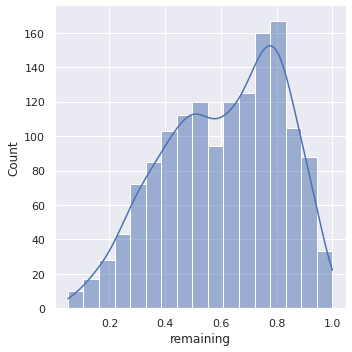

In [127]:
non_legendary_pair_completeness = pair_completeness[dfp_cards["rarity"]!="legendary"]
sns.displot(x=non_legendary_pair_completeness,kde=True)

<AxesSubplot:xlabel='remaining', ylabel='Proportion'>

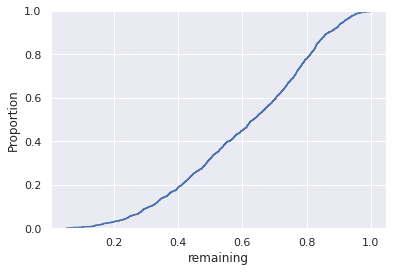

In [128]:
sns.ecdfplot(x=non_legendary_pair_completeness)

In [129]:
(pair_completeness[dfp_cards["rarity"]!="legendary"] > 0.8).mean()

0.22064777327935223

<AxesSubplot:xlabel='remaining'>

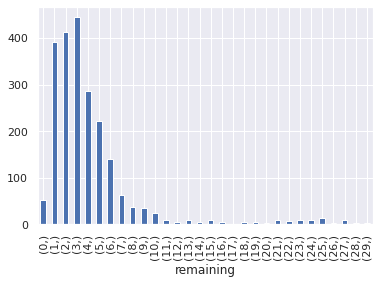

In [130]:
# how popular is any given # of unique non-legendary cards for decks?
remaining_sum_test = _.groupby("deckid").agg({"remaining":np.sum}).value_counts().sort_index()
remaining_sum_test.plot(kind='bar')

<AxesSubplot:xlabel='remaining'>

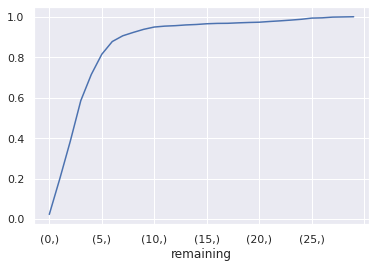

In [131]:
(remaining_sum_test.cumsum() / remaining_sum_test.sum()).plot()

We see that 80\% of the test set decks have at most 5 unique non-legendary cards. We can tune from the validation set the minimum completeness level as to maximize the LB performance.

In [132]:
# class version
class MissingCopyCorrector:
    def fit(self, df_train, df_cards, deck_key="cards"):
        aux = (
            df_train[["deckid",deck_key]]
            .explode(deck_key)
            .groupby(["deckid",deck_key])
            .size()
            .rename("count")
            .reset_index()
            .merge(df_cards["max_count"],right_index=True, left_on=deck_key)
        )

        aux["remaining"] = aux["max_count"] - aux["count"]
        
        self.df_cards = df_cards[["max_count"]].copy()
        self.df_cards["pair_completeness"] = 1 - (
            aux
            .groupby(deck_key)
            .agg({"remaining":np.mean})
        )["remaining"]
        return self
    
    def recommend_one(self, deck, min_completeness, max_k):
        aux = (
            self.df_cards[["pair_completeness","max_count"]]
            .merge(pd.value_counts(deck).rename("count"), left_index=True, right_index=True)
        )
        # keep only those cards where remaining > 0 and pair_completeness > min_completeness, sort by pair_completeness
        aux = aux[(((aux["max_count"] - aux["count"]) > 0) & 
                   (aux["pair_completeness"] > min_completeness))].sort_values("pair_completeness", ascending=False)
        
        return aux.index.to_list()[:max_k]
        
    def predict(self, df_test, deck_key="cards_incomplete", min_completeness=0.8, max_k=3):
        return [self.recommend_one(deck, min_completeness, max_k) for deck in df_test[deck_key]]

In [133]:
m4_valid_corrections = (MissingCopyCorrector()
                        .fit(X_train, dfp_cards)
                        .predict(X_valid, min_completeness=0.8, max_k=3))

m4_valid_preds = append_corrections(preds=m1_valid_preds,
                                    corrections=m4_valid_corrections,
                                    k_corrections=3,
                                    k_predictions=3)

#ndcg1(y_valid,m3_valid_preds), map3(y_valid, m3_valid_preds)
report(y_valid,m4_valid_preds, X_valid["hero"])

Mean MAP@3: 0.47135
Mean NDCG1: 0.4284


,MAP@3,NDCG1
hero,,
druid,0.52000,0.48309
hunter,0.45614,0.43212
mage,0.38462,0.33856
paladin,0.49524,0.44580
priest,0.41346,0.36206
rogue,0.52893,0.49105
shaman,0.35385,0.34048
warlock,0.60870,0.54037
warrior,0.50000,0.44808


In [134]:
# now also with DuplicateCorrector on top (as it is a more specific correction)
m4_valid_preds_with_2 = append_corrections(preds=m4_valid_preds,
                                           corrections=m2_valid_corrections,
                                           k_corrections=3,
                                           k_predictions=3)

report(y_valid,m4_valid_preds_with_2, X_valid["hero"])

Mean MAP@3: 0.5616
Mean NDCG1: 0.52224


,MAP@3,NDCG1
hero,,
druid,0.60000,0.56309
hunter,0.50877,0.47828
mage,0.48352,0.42530
paladin,0.61905,0.56837
priest,0.56731,0.52198
rogue,0.62810,0.60350
shaman,0.40000,0.39432
warlock,0.63768,0.58385
warrior,0.52778,0.48611


In [135]:
for k_corrections in range(1,4):
    _ = append_corrections(preds=m4_valid_preds,
                           corrections=m2_valid_corrections,
                           k_corrections=k_corrections,
                           k_predictions=3)
    print(k_corrections,"->",map3(y_valid, _))

1 -> 0.5558739255014327
2 -> 0.5616045845272206
3 -> 0.5616045845272206


In [136]:
# now that we're sure the best we can do is MissingCopy(3) -> Duplicate(3), grid search over min_completeness
GRID_SEARCH_MIN_COMPLETENESS = True
if GRID_SEARCH_MIN_COMPLETENESS:
    x = np.linspace(start=0, stop=1, num=20)
    def measure_performance(min_completeness):
        m4_valid_corrections = (MissingCopyCorrector()
                                .fit(X_train, dfp_cards)
                                .predict(X_valid, min_completeness=min_completeness, max_k=3))

        m4_valid_preds = append_corrections(preds=m1_valid_preds,
                                            corrections=m4_valid_corrections,
                                            k_corrections=3,
                                            k_predictions=3)

        m4_valid_preds_with_2 = append_corrections(preds=m4_valid_preds,
                                                   corrections=m2_valid_corrections,
                                                   k_corrections=3,
                                                   k_predictions=3)

        y_true = y_valid
        y_preds = m4_valid_preds_with_2
        return (map3(y_true, y_preds), ndcg1(y_true,y_preds))

    y_map3, y_ndcg1 = zip(*[measure_performance(k) for k in tqdm(x)])

100%|██████████| 20/20 [05:05<00:00, 15.29s/it]


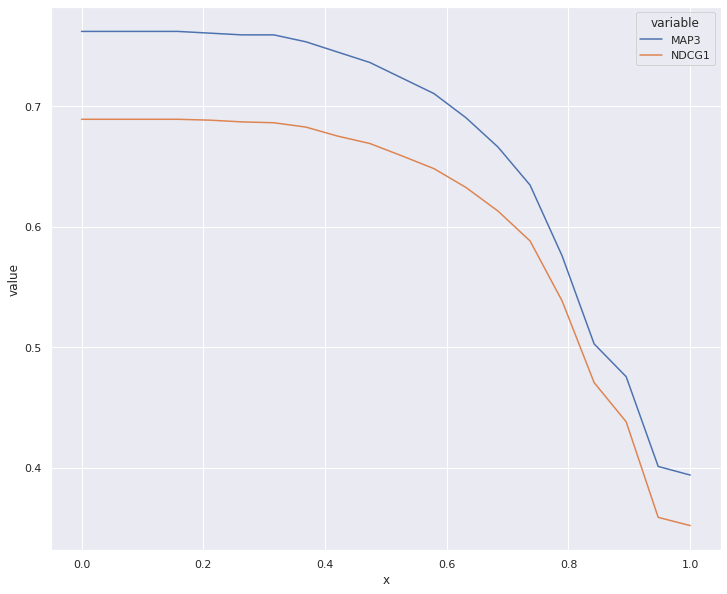

In [137]:
if GRID_SEARCH_MIN_COMPLETENESS:
    fig, ax = plt.subplots(figsize=(12,10))
    _ = pd.DataFrame({"x":x, "MAP3":y_map3, "NDCG1":y_ndcg1}).melt("x", ["MAP3", "NDCG1"])
    sns.lineplot(data=_, x="x", y="value", hue="variable", ax=ax)
    plt.show()

In [138]:
if GRID_SEARCH_MIN_COMPLETENESS:
    print(x[np.argmax(y_map3)])

0.0


In [139]:
if GRID_SEARCH_MIN_COMPLETENESS:
    print(y_map3[0], y_ndcg1[0])

0.7621776504297995 0.6892449503684036


Contrary to what we'd have assumed, it seems that using the top 3 options for correction is *always* better, no matter how rare it is for the pair to be completed in the train set. This performance is kept stable until min\_completeness is around 0.3, suggesting that *in practice <0.3-completeness pairs are rarely suggested*. This raises the question about whether the actual best min\_completeness value is somewhere in between 0 and 0.3 but we can't observe it, but there's not much we can do without generating another temporal split (which would in turn raise doubts about distribution shifts).

In [140]:
# submit this last version
m4 = MissingCopyCorrector().fit(dfp_train, dfp_cards)
m4_corrections = m4.predict(dfp_test, min_completeness=0, max_k=3)
m1_preds_corrected_4 = append_corrections(popular_by_hero_preds,m4_corrections)
m4_preds_corrected_2 = append_corrections(m1_preds_corrected_4,m2_preds)

submit(dfp_test["deckid"], m4_preds_corrected_2).to_csv("missing_pair.csv",index=False)

**summary V2:**

Submission | LB MAP@3 | Valid MAP@3 | NDCG1 | Ratio LB/Valid MAP@3
:---: | :---:  |:---: | :---:  | :---:  
\[>2 included\] Popular | 0.17251 | 0.2432 | 0.2523 | 0.70933
\[>2 included\] Duplicate correction (all 3) | 0.29492 |  0.40057 | 0.39804 | 0.73625
Popular | 0.17191 | 0.24069 | 0.25096 | 0.7142
Duplicate correction (all 3) | 0.29432 | 0.39398 | 0.39516 | 0.7470
Popular+MissingCopy+Duplicate | 0.63576 | 0.76218 | 0.68977 | 0.83413

At submission this model led to the 5th rank in the public LB, which is extremely high considering it's made up of 3 non-ML models, just backed up by HS (or just plain TCG?) concepts:
1. Popular cards are so because they're picked in many decks
2. If two decks have 29 cards in common it's highly probable that the 30th one is the same
3. There are, broadly speaking, two kind of cards in a deck: those that fit the deck's theme, and tech cards. The first kind are assumed to benefit your deck, hence one should include as many copies of each as possible while the second are specific answers to other decks (e.g. [Dirty Rat](https://hearthstone.fandom.com/wiki/Dirty_Rat) vs OTK/Reno decks) and represent a deviation of the deck's theme, which leads to only keeping a single copy unless the card in itself is strong. One basic approach is, for decks that feature a single copy of a card that's usually included in pairs, suggesting the "missing" copy.

In [141]:
# submit last one
submission = "missing_pair"

In [142]:
os.rename(f"{submission}.csv","submission.csv")